# 05_Ensemble_Eval_with_Keywords.ipynb - Enhanced Ensemble with Keyword Flag

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
import joblib
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load and prepare data
df = pd.read_csv('../fake_job_postings.csv')
df['description'] = df['description'].fillna("")

# Create suspicious keyword flag
suspicious_keywords = r"(money|earn|transfer|urgent|wire|click here|quick cash|work from home|guarantee|easy|no skills|required|start immediately|instant payments|limited spots|flexible hours|sign up now|$\\d+|act now)"
df['has_suspicious_terms'] = df['description'].str.contains(suspicious_keywords, case=False, regex=True).astype(int)

# Prepare features and target
X_text = df['description']
X_meta = df[['has_suspicious_terms']]
y = df['fraudulent']

# Split the data
X_train_text, X_test_text, X_train_meta, X_test_meta, y_train, y_test = train_test_split(
    X_text, X_meta, y, test_size=0.2, stratify=y, random_state=42)

C:\Users\arpit\AppData\Local\Temp\ipykernel_17840\3035139564.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['has_suspicious_terms'] = df['description'].str.contains(suspicious_keywords, case=False, regex=True).astype(int)


In [3]:
# Vectorize text
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_vec = tfidf.fit_transform(X_train_text)
X_test_vec = tfidf.transform(X_test_text)

# Convert metadata to sparse and combine
X_train_meta_sparse = csr_matrix(X_train_meta.values)
X_test_meta_sparse = csr_matrix(X_test_meta.values)

X_train_combined = hstack([X_train_vec, X_train_meta_sparse])
X_test_combined = hstack([X_test_vec, X_test_meta_sparse])

In [4]:
# Define base models
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
lr = LogisticRegression(max_iter=500, class_weight='balanced')
nb = MultinomialNB()


# Ensemble model
ensemble = VotingClassifier(estimators=[
    ('rf', rf),
    ('lr', lr),
    ('nb', nb)
], voting='soft')

# Train ensemble
ensemble.fit(X_train_combined, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('lr',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=500)),
                             ('nb', MultinomialNB())],
                 voting='soft')

In [5]:
# Evaluate
y_pred = ensemble.predict(X_test_combined)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, ensemble.predict_proba(X_test_combined)[:, 1]))

[[3399    4]
 [  86   87]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.96      0.50      0.66       173

    accuracy                           0.97      3576
   macro avg       0.97      0.75      0.82      3576
weighted avg       0.97      0.97      0.97      3576

ROC AUC Score: 0.9595171890154726


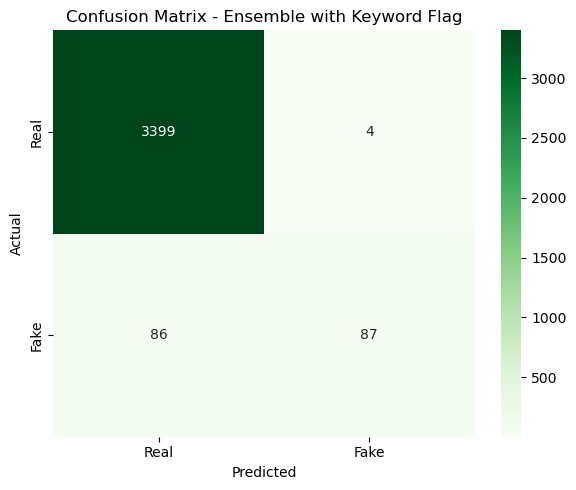

In [6]:
# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Ensemble with Keyword Flag')
plt.tight_layout()
plt.show()

In [7]:
# Save model and vectorizer
joblib.dump(ensemble, '../models/ensemble_model.pkl')
joblib.dump(tfidf, '../models/ensemble_vectorizer.pkl')

['../models/ensemble_vectorizer.pkl']